In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pandas as pd
%matplotlib inline
from IPython.display import Image
import pystan
import AngStII_Bayes as bayes

# Punktschätzer, Intervallschätzer, Tests

- Frequentistische Statistik
    - Versuchs-Intention
    - Punktschätzer
    - Vertrauens-/Konfidenzintervall *CI*
    - p-Wert
- Bayes Statistik
    - Wissensverbesserung
    - credible interval *CI*/*HDI*
    - Akzeptanzbereich, region of practical equivalence *ROPE*
    - Bayes-Faktor
    - Ergebnis

# Frequentistische Statistik

## Experimente 
Wieder stellvertretend für alle Ja/Nein Experimente der Münzwurf
1. Experiment: $\quad 24\times$ Werfen
2. Experiment: $\quad$Werfen bis $7\times$ *Kopf*
3. Experiment: $\quad 2$ Minuten werfen

#### Versuchsergebnis 
- $7\times$ *Kopf* von $24$ Würfen

#### p-Wert
- **?**

## Experiment 1: 24x werfen
Verwerfungsbereich (mit Irrtumswahrscheinlichkeit $\alpha=5\%$)

In [3]:
N = 24                              # #-tosses
z = 7                               # #-heads 
theta = 0.5                         # null hypothesis
n1, n2 = stats.binom(N, theta).ppf((0.025, 0.975))
print('rejection region with alpha={} is z<{:.0f} or z>{:.0f}'
                              .format(.05, n1, n2))

rejection region with alpha=0.05 is z<7 or z>17


In [5]:
'''p-values for two-sided and both one-sided tests against H0: theta=0.50'''
# p-value by built in test
print('pval_twosided = {:.5f}'.format(stats.binom_test(z, N, 0.5)))
# p-value if <= z
print('pval_lower    = {:.5f}'.format(stats.binom(N, theta).cdf(z)))
# p-value if >= z
print('pval_upper    = {:.5f}'.format(1-stats.binom(N, theta).cdf(z)))

pval_twosided = 0.06391
pval_lower    = 0.03196
pval_upper    = 0.96804


The result [z=7 heads under N=24 tosses] has a p-value of 0.06391
The null hypothesis "fair theta=0.500" will not be rejected under alpha=0.050


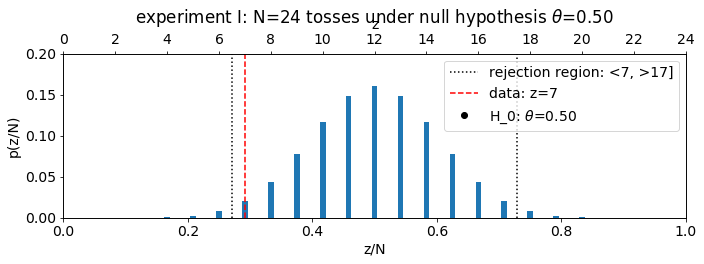

In [6]:
'''experiment 1)  z=7 heads under N=24 tosses'''
nj = np.linspace(0, N, N+1)               # divide in n equal steps for N
pj = stats.binom(n=N, p=.5).pmf(nj)       # probability of z under N=xn
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,1,1)
ww=0.0045          # distribution with small bars showing discrete values
plt.bar(left=nj/N, height=pj, width=2*ww, bottom=0.)
plt.xlim(0, 1)
plt.ylim(0, .2)
plt.xlabel('z/N')
plt.ylabel('p(z/N)')
plt.plot(2*[(n1-.5)/N], [0, 0.2], 'k:',   # two sided CI: lower
         label='rej.reg. <{:.0f}, >{:.0f}]'.format(n1, n2))   
plt.plot(2*[(n2+.5)/N], [0, 0.2], 'k:')   # and  upper bound 
plt.plot(2*[z/N], [0, 0.2], 'r--', label='data: z=7')
plt.plot(-2, -2, 'ko', label='H_0: $\\theta$=0.50')
plt.legend(loc='upper left', fontsize=12)
plt.title('experiment I: N=24 tosses under null hypothesis $\\theta$=0.50', y=1.15)
ax2 = ax1.twiny()   # mirror the x-axis, show additionally labels for z
ax2.set_xticks(nj[::2])
ax2.set_xlabel('z')
plt.tight_layout();
# and the (the?) p-value
alpha = .05        # 5% confidence limit
pval = stats.binom_test(x=z, n=N, p=theta, alternative='two-sided')
print('The result [z={} heads under N={} tosses] has a p-value of {:.5f}'
                  .format(z, N, pval))
'not '  if pval >= alpha else ' '
print('The null hypothesis "fair theta={:.3f}" will {}be rejected under alpha={:.3f}'
      .format(theta, 'not ' if pval >= alpha else ' ', alpha))

## Experiment 2: werfen bis 7 Köpfe

Was ist der Verwerfungsbereich auf $\alpha=5\%$-Niveau?

    stats.nbinom?
    
    Negative binomial distribution describes a sequence of i.i.d. Bernoulli 
    trials, repeated until a predefined, non-random number of successes occurs.

    The probability mass function of the number of failures for `nbinom` is::
        nbinom.pmf(k) = choose(k+n-1, n-1) * p**n * (1-p)**k
        for ``k >= 0``.

    `nbinom` takes ``n`` and ``p`` as shape parameters 
    where n is the number of successes, 
    whereas p is the probability of a single success.
    

In [7]:
'''experiment 2) - intention: number of trials under fixed number of successes'''
theta = 0.5                 # null hypothesis' fair 50% heads
z = 7                       # heads, number of successes planned
N = 24                      # tosses, number of trials obtained
n = z                       # nbinom parameter successes
k = N-z                     #                  failures 

In [8]:
'''calculate ETI (Equally tailed confidence interval)'''
# symmetrical +/-2,5% rejection region
ki = np.asarray(stats.nbinom(n, theta).interval(.95))
Ni = ki+z   # back-transformed to ntotals
print('equally tailed rejection region with alpha=2x{:.3f} is N<{:.0f} or N>{:.0f}'
                  .format(.05/2, Ni[0], Ni[1]))

equally tailed rejection region with alpha=2x0.025 is N<8 or N>23


In [9]:
def intervalasym(distrib, cred=.95):
    '''calculate discrete, asymmetric rejection region of a monomodal 
            probability distribution
       input:
           distrib: frozen distribution; must have .ppf() and .pmf()
              cred:    cred mass; between 0 and 1, default=.95
       output:
           interval as tuple, including lowest up to highest value of x in distrib
       rem: it is intended, that cred mass is lower than asked
            but would be higher if one of the two border would be exceeded,
            both are constructed to have comparable height'''
                                # range of probabilities, big enough
    nj = np.arange(distrib.ppf(.001), distrib.ppf(.999))
    pj = distrib.pmf(nj)        # collect probabilities within this range
                                # make a suitable dataframe with indices
    df = pd.DataFrame({'n': nj, 'p': pj})
                                # sort and cumulate up to credible mass
    df.sort_values('p', ascending=False, inplace=True)
    dfc = df[df['p'].cumsum()<=.95] # select mass up to cred mass
    return (dfc['n'].min() , dfc['n'].max()) # min and max of index are borders

'''calculate asymmetrical two sided rejection regions of
intention "trials until successes'''
negbinom7 = stats.nbinom(n, theta)  # freeze distribution
# get two-sided asymmetrical 5% rejection regions
k1, k2 = intervalasym(negbinom7, .95)
# append back-transform to ntotal to [3, 4] (once!)
Ni = np.hstack((Ni, (k1+z, k2+z)))
print('asymmetrical rejection region with alpha={:.3f} is N<{:.0f} or N>{:.0f}'
      .format(.05, Ni[2], Ni[3]))

asymmetrical rejection region with alpha=0.050 is N<8 or N>20


N=24 tosses under z=7 heads has a one sided upper p-value of 0.01734
The null hypothesis "fair p=0.500" will be rejected under alpha=0.025


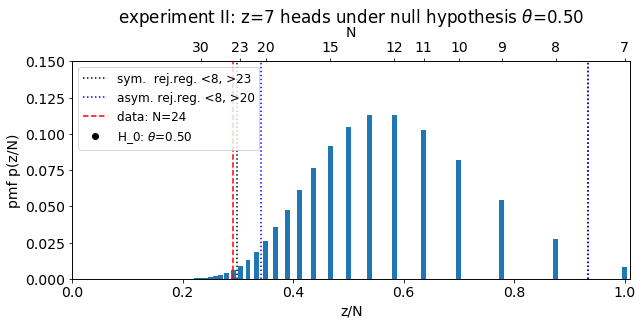

In [10]:
'''experiment 2) - intention: number of trials under fixed number of successes'''
# divide in n equal k-steps for z/N down to 1/100
kj = np.linspace(0, 100, 100+1)
pj = stats.nbinom(n, theta).pmf(kj) # probabilities for failures k=N-z
qj = n/(kj+n)                       # grid of z/N to compare with trial #1
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,1,1)
plt.bar(left=qj, height=pj, width=0.009, bottom=0.)
plt.xlim(0, 1.01)
plt.ylim(0, .15)
plt.xlabel('z/N')
plt.ylabel('pmf p(z/N)')
plt.plot(2*[n/(Ni[0]-z-.5+n)], [0, 0.15], 'k:', # two sided CI: lower
         label='sym.  rej.reg. <{:.0f}, >{:.0f}'.format(Ni[0], Ni[1]))   
plt.plot(2*[n/(Ni[1]-z+.5+n)], [0, 0.15], 'k:') #          and  upper bound 
plt.plot(2*[n/(Ni[2]-z-.5+n)], [0, 0.15], 'b:', # two sided CI: lower
         label='asym. rej.reg. <{:.0f}, >{:.0f}'.format(Ni[2], Ni[3]))   
plt.plot(2*[n/(Ni[3]-z+.5+n)], [0, 0.15], 'b:') #          and  upper bound 
plt.plot(2*[n/24], [0, 0.15], 'r--', label='data: N=24')
plt.plot(-2, -2, 'ko', label='H_0: $\\theta$=0.50')
plt.legend(loc='upper left', fontsize=12)
ax2 = ax1.twiny()                          # mirror the x-axis
values = [0, 1, 2, 3, 4, 5, 8, 13, 16, 23] # select not too dense for higher
# shift as set in xlim above
plt.xticks(qj[values]*.99, np.rint(z+kj[values]).astype(int))
ax2.set_xlabel('N')
plt.title('experiment II: z=7 heads under null hypothesis $\\theta$=0.50', y=1.15);
# and the (other!) p-value
pval = 1-stats.nbinom(z, theta).cdf(N-z-1)
print('N={} tosses under z={} heads has a one sided upper p-value of {:.5f}'
      .format(N, z, pval))
t = ' not '  if pval >= alpha/2 else ' '
print('The null hypothesis "fair p={:.3f}" will{}be rejected under alpha={:.3f}'
      .format(theta, t, alpha/2))

## Frequentistische Statistik

Vergleich zwischen Versuch 1) und Versuch 2) mit unterschiedlicher Intention:

#### Gleiche Versuchsdaten 

- $N=24$ Würfe
- $z=7$ Köpfe

#### Versuch 1)

- Intention: feste Anzahl werfen, wie viele Erfolge darunter?
- $\Rightarrow$ Nullhypoothese "*Münze ist fair*" wird **nicht verworfen**

#### Versuch 2) 

- Intention: werfen, bis feste Anzahl Erfolge, wie oft insgesamt geworfen?
- $\Rightarrow$ Nullhypoothese "*Münze ist fair*" wird **verworfen**


## Experiment 3: Zwei Minuten lang werfen

**[ÜA]**

Abstand zweier Würfe sei *Poisson*-verteilt mit $\lambda=5$

Was ist der Verwerfungsbereich auf $\alpha=5\%$-Niveau?

    After two minutes: N=24 tosses and z=7 heads obtained
    This result has a one-sided p-value of 0.024 
    The null hypothesis "fair p=0.500" will barely be rejected under alpha=0.025

## Zusammenfassung Frequentistische Statistik

Das Beispiel ($z=7$, $N=24$) hat 

- Punktschätzer $\qquad\qquad \widehat\theta = \frac{z}{N} = 0.2917$

- Vertrauensintervall(e)

$$\begin{aligned}
\theta_{N=24}&   \in [0.126,\,0.511]\quad \text{auf} \quad &\alpha=5\% \\
\theta_{z=7}&    \in [0.126,\,0.484]\quad \text{auf} \quad &\alpha=5\% \\
\theta_{t=2min}& \in [0.135,\,0.497]\quad \text{auf} \quad &\alpha=5\%
\end{aligned}$$

- p-Wert(e) unter Nullhypothese $\theta=\frac{1}{2}$ 

$$\begin{aligned}
p\!-\!val_{N=24} &= 0.064 \quad \text{auf} \quad &\alpha=5\% \\
p\!-\!val_{z=7} &= 0.025 \quad  \text{auf} \quad &\alpha=5\% \\
p\!-\!val_{t=2min} &= 0.049 \quad  \text{auf} \quad &\alpha=5\% \\
\end{aligned}$$

### Intention

Obwohl das Versuchsergebnis das selbe ist, ist die Schlußfolgerung abhängig von der Intention des Versuches

#### Relevanz für Praktiker

- Situation entschärft für große N
- Problem bleibt bestehen für kleine N
- Problem kann für bestimmte Verteilungen dramatisch sein

# Bayes-Statistik

- Bayes Schlußfolgerung hängt nicht von Intention ab, sondern von der *Likelihood*.
- Diese ist für alle Versuchsintentionen die selbe.

> Es ist stets mit Likelihood

- Mit der mathematisch geschlossenen Lösung für den Posterior für $\theta$ ergibt sich
    - HDI [0.125, 0.474] 
    - enthält Nullhypothese $\theta_0=\frac{1}{2}$ nicht

posterior HDI=[0.125, 0.474]


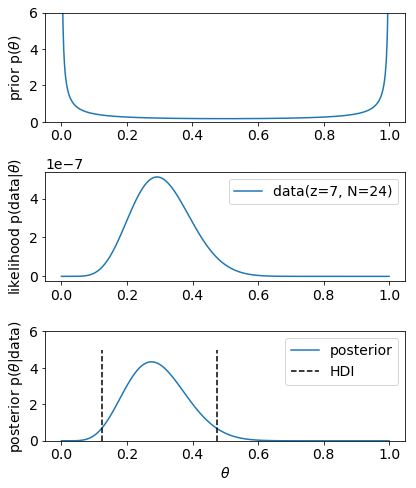

In [12]:
'''Bayes exact with Beta distribution'''
a, b = (0.1, 0.1)                    # Prior (inbetween haldane and uniform)
z, N = 7, 24                         # Data: 7 heads among 24 tosses
thetas = np.linspace(0., 1., 1001)   # range of possible thetas
prior = stats.beta(a, b).pdf(thetas) # Prior distribution over theta
likelihood = thetas**z * (1-thetas)**(N-z)      # p(D|N,z)
posterior = stats.beta(a+z, b+N-z).pdf(thetas)  # from theory ...
f = plt.figure(figsize=(6, 7)) # big figure, space to hold 3 subfigures
f.add_subplot(3, 1, 1) # 1st subfigure (top of 3)
plt.plot(thetas, prior)# prior distribution of theta  
plt.ylim(0, 6.)        # same height as later for comparison
plt.ylabel(r'prior p($\theta$)')
f.add_subplot(3, 1, 2) # 2nd subfigure (middle); for likelihood(data|theta)
plt.plot(thetas, likelihood, label='data(z=7, N=24)')                    
plt.ylabel(r'likelihood p(data|$\theta$)')
plt.legend(loc='upper right')
f.add_subplot(3, 1, 3)                        # 3rd subfigure (lowest of 3)
plt.ylim(0, 6.)                               # same as top subfigure 
plt.plot(thetas, posterior, label='posterior')# posterior distribution of theta
plt.ylabel(r'posterior p($\theta$|data)')
plt.xlabel(r'$\theta$')
# Highest Density Interval: contains 95% of probabilities inside
hdi = bayes.HDIofICDF(stats.beta, credmass=0.95, a=a+z, b=N-z)
plt.plot(2*[hdi[0]], [0, 5], 'k--', label='HDI')
plt.plot(2*[hdi[1]], [0, 5], 'k--')
print('posterior HDI=[{:.3f}, {:.3f}]'.format(hdi[0], hdi[1]))
plt.legend(loc='upper right')
plt.tight_layout();

In [13]:
'''Bayes MCMC with Beta distribution'''
y = np.asarray(7*[1]+(24-7)*[0]) # an arbitrary fake result vector
data = {
    'N': len(y),
    'y': y
}

model = """
data {
    int<lower=0> N;          // number of schools
    int y[N];                // estimated treatment effects
}
parameters {
    real<lower=0> theta;     // the parameter of question
}
model {
    y ~ bernoulli(theta);    // likelihood
    theta ~ beta(0.5, 0.5);  // prior
}       """

fit = pystan.stan(model_code=model, data=data, warmup=200, iter=2000,
                  chains=4, n_jobs=4, model_name='bayes')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bayes_b85ec688330bca4a0ae7766e45f55dee NOW.


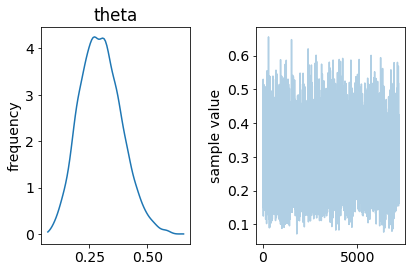

In [14]:
mygraph = fit.plot()
plt.tight_layout();

In [15]:
'''HDI calculated by Pystan MCMC'''
thechain = fit.extract('theta')['theta'] # fetch chain for calculation of HDI
alpha = .05                              # 5% significance level
hdi = bayes.HDIofMCMC(thechain, 1-alpha) # compute HDI of posterior mcmc chain
print('theta HDI({:.1f}%)=[{:.3f}, {:.3f}]'
          .format(100*(1-alpha), hdi[0], hdi[1]))

theta HDI(95.0%)=[0.126, 0.468]


## Ergebnis Bayes-Statistik

#### gleiche Versuchsdaten wie oben

- $N=24$ Würfe
- $z=7$ Köpfe

#### von Intention unabhängig

- Posterior kann mit jedem Einzelergebnis erneuert werden

#### Versuchsauswertung

- Posterior direkt interpretierbar als Verlässlichkeit von $\theta$: durch $p(\theta|D)$
- Posterior HDI enthält den Parameter der Nullhyppothese **nicht**
    - `[0.125, 0.474]` mittels mathematisch geschlossener Lösung beta-Verteilung
    - `[0.120, 0.468]` mittels MCMC
- $\Rightarrow$ Nullhypoothese "*Münze ist fair*" wird **verworfen**
    - (*ROPE* siehe später)

### MAP und HDI hängen vom Prior ab

- *maximum-a-posterior* als Punktschätzer
- *credible interval* *HDI*
- Vorteil: man *kann* sein Vorwissen im Prior weiterverwenden

## Ominöser Prior?

Man muß sich auf Prior einigen. 

- Theorie (Verteilungen ...)
- Vorwissen durch andere Veröffentlichungen
- Vorversuche

Selbst wenn "*agree to disagree*":

- dann kann man beide Varianten berechnen.

Ähnliches Problem bei NHST:

- welche Verteilung ist angemessen?

> Es soll auf Prior einigen

### Unwissender Prior?

- *indifferent* Prior
    - $p(\theta) = const.$ 
    - Bernoulli-Experiment: $p(\theta) = 1 = \mathrm{beta}(1, 1)$
- Jeffreys Prior 
    - invariant unter Koordinatentransformation
    - Bernoulli-Experiment: $p(\theta) = \mathrm{beta}(\frac{1}{2}, \frac{1}{2})$
    - [Jeffreys: An Invariant Form for the Prior Probability in Estimation Problems. Proceedings of the Royal Society of London. Series A, Mathematical and Physical Sciences. 186 (1007): 453–461. JSTOR 97883 (1946)](http://rspa.royalsocietypublishing.org/content/186/1007/453)
- Haldane Prior
    - als ob *keinerlei* Vorwissen
    - Bernoulli-Experiment: $p(\theta) = \mathrm{beta}(\epsilon, \epsilon)$
    - [Haldane: A note on inverse probability. Mathematical Proceedings of the Cambridge Philosophical Society. 28: 55–61 (1932)](https://www.cambridge.org/core/journals/mathematical-proceedings-of-the-cambridge-philosophical-society/article/note-on-inverse-probability/1BC33DBEA96916D0A31998DCD5CA6D3B)

> Jeffreys Prior: 

# Entscheidung mit Bayes-Statistik

### HDI 

- Fällt der zu testende Parameter-Wert $\theta_x$ in das *credible interval*, den Bereich der höchsten Dichte "*HDI*"?
    - $\theta_x \in \mathrm{HDI}$

### Bayes Faktor

- Beschreibt der gesuchte Parameter $\theta_x$ die Daten besser als andere?
- Vergleich mit einem weiten Bereich von möglichen Parametern

# HDI und *ROPE*

"*Region of Practical Equivalence*" definiert denjenigen Bereich an Parametern
- der für die Anwendung relevant ist
- ob Unterschiede in $\theta$ sich auf das Verhalten auswirken

Beispiel: Münze für Fußballanstoß darf $\;\mathrm{ROPE} = [0.45 ... 0.55]\;$ haben.
    
Definition: Nullhypothese

## Sind die Daten mit der *ROPE* vereinbar?
Irrtumswahrscheinlichkeit $\alpha$ zB. $\alpha=5\%$ 

### Verwerfen
Verwerfen der Nullhypothese genau dann, wenn $(1\!-\!\alpha)$-HDI und ROPE keinen Überlapp zeigen

### Akzeptieren
Akzeptiere die Nullhypothese genau dann, wenn gesamtes $(1\!-\!\alpha)$-HDI innerhalb der ROPE

> nie die Ausage nicht vorwerfen, nicht die Frage Stellung.
nullhypothese zu verwerfen.

### Graubereich

- ROPE innerhalb breitem HDI
    - zu ambitionierte Vorgabe
    - zu wenig Daten

### sub-optimal

HDI liegt innerhalb ROPE, aber HDI enthält $\theta_{0}$ selbst nicht
- ROPE zu weit
- Modell könnte besser sein (Prior)

In [16]:
'''compare ROPE to HDI'''
import AngStII_Bayes as bayes           # contains HDI computation

theta0 = .500                           # Null-hypothesis "fair"
rope = [theta0-.025, theta0+0.025]      # ROPE around Null-hypothesis' theta

thechain = fit.extract('theta')['theta']# fetch chain for calculation of HDI
alpha = .05                             # 5% significance level
hdi = bayes.HDIofMCMC(thechain, 1-alpha)# compute HDI of posterior mcmc chain

decision = 'ambigous'                   # default setting to start with 
if rope[0]>hdi[1] or rope[1]<hdi[0]:    # hdi separated from rope
    decision = 'reject'
if rope[0]<hdi[0] and rope[1]>hdi[1]:   # hdi completely inside rope
    decision = 'accept'
# within rope but null hypothesis not in hdi
if decision == 'accept' and not (hdi[0] < theta0 < hdi[1]):
    decision = 'sub optimal'

print('theta ROPE=[{:.3f}, {:.3f}]  {:.1f}%-HDI=[{:.3f}, {:.3f}] => '
      '{} null hypothesis H0: theta0={:.3f}'.
      format(rope[0], rope[1], 100*(1-alpha), hdi[0], hdi[1], decision, theta0))

theta ROPE=[0.475, 0.525]  95.0%-HDI=[0.126, 0.468] => reject null hypothesis H0: theta0=0.500


## Entscheidung

- Jede Entscheidung reduziert die vorliegenden Daten/Berechnungen auf einen binären Wert
    - beispielsweise die Posterior-Verteilung auf verwerfen/nicht-verwerfen

- In der Posterior-Verteilung steckt jedoch mehr Information
    - Damit kann jeder *seine* Entscheidung fällen.

- Äquivalent aus den Statistik-Grundlagen Frequentistische Statistik:
    - Punkt (Ort, Schätzer)
    - Intervall (Breite)
    - Verteilung (Form ...)

- Wenn insbesondere Stichproben erhoben werden (zB. durch MCMC)
    - spielt die Grenze der Intervalle eine Rolle
    - variiert selbst.

- Beispielsweise MCMC
    - 10.000 *effective sample size* 
    - $\Rightarrow$ SD des 95%-HDI ist $\sim5\%$ der SD des Posteriors (bei Normalverteilung)

> Ist genau genug

# Eigenschaften

## Parameter-Relation: z.B. Differenz

Aus den Randverteilungen lassen sich keine Schlüsse ziehen, aus dem Gesamt-Modell durchaus.

> Ausage machen, beide Wahrscheinlichkeit ausbauend machen

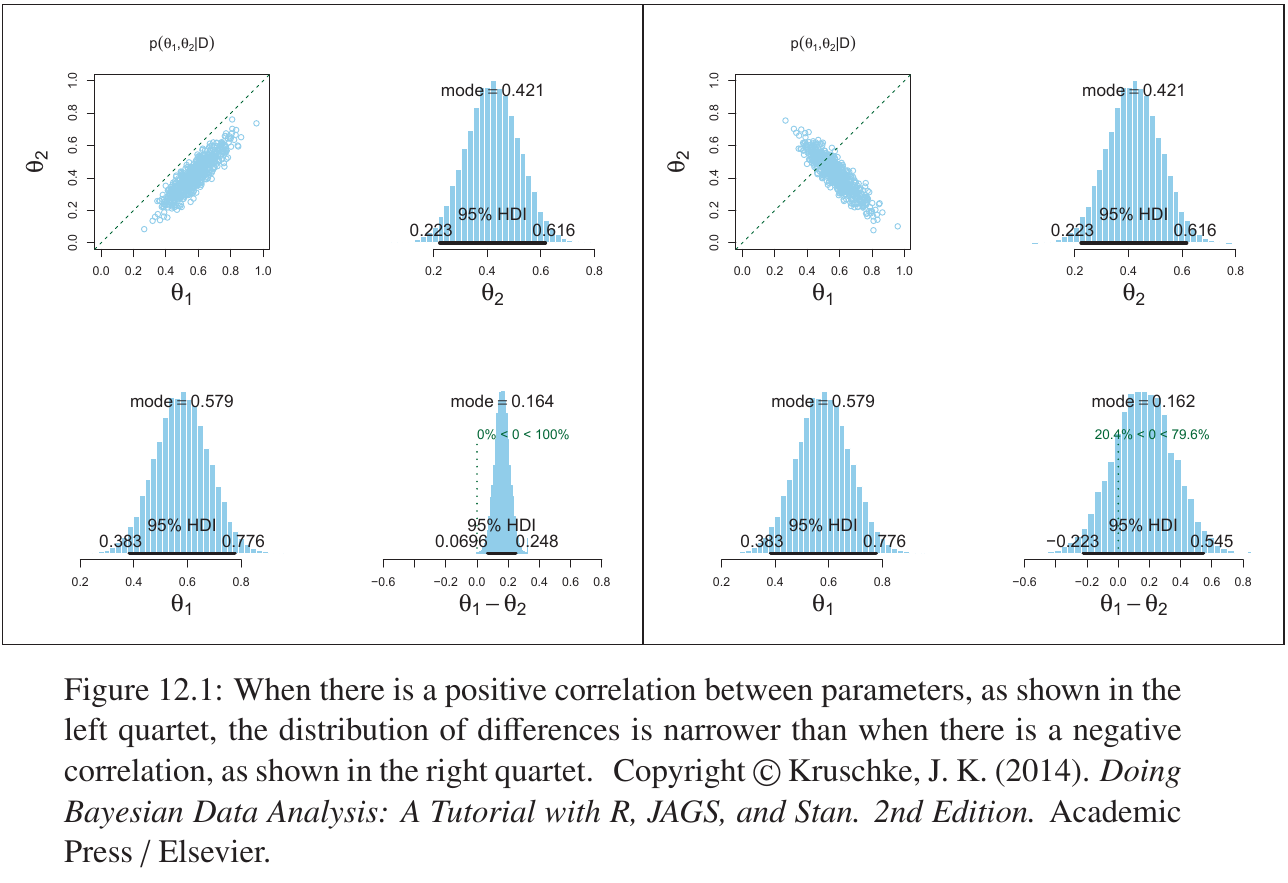

In [41]:
Image(filename='images/Kruschke2nd_OneModel_Fig12p1.png', width='75%')

## Mehrfach-Vergleiche

Kumulierte $\alpha$-Fehler sind problematisch (Erinnerung Angewandte Statisik I)

Bayes-Statistik beschreibt ein (Gesamt-) Modell, unproblematisch.

## Posterior Vorhersage

Bayes-Statistik bestimmt die relative Verteilung der Parameter.

#### Guter Schätzer?

Ob der MAP-Schätzer ein guter Schätzer ist, muß getestet werden:

#### Beispiel

Wir gehen von einer 1% oder 99% Trick-Münze aus. 

Ergebnis ist 30/40.
- Beide Modelle sind schlecht:
- Das 99%-Modell ist jedoch viel weniger schlecht als das 1%-Modell

#### Sehen Daten aus dem geschätzen Modell den gemessenen ähnlich?

$\Rightarrow$ Dann ist das Modell angemessen.

## *Equally Tailed Interval* (*ETI*) 同等间隔

- 95%-ETI schneidet auf beiden Seiten 2.5% der Wahscheinlichkeit ab
- andere Gewichtung: absolute Wahrscheinlichkeit
- ETI läßt sich leichter berechnen (''ppf'')
- ETI ist invariant unter Transformation
    - Für HDI sinnvolle Bedeutung der Parameter wählen

> sym & asym
>
> order locker

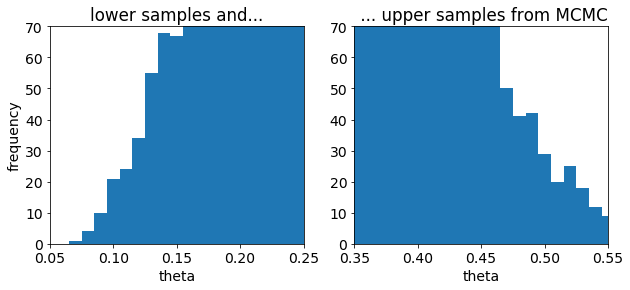

In [17]:
'''histogram with bins size 1/100'''
bins = np.linspace(-0.005, 1.005, 101+1)
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.hist(thechain, bins=bins)
plt.title('lower samples and...')
plt.xlim(0.05, 0.25)
plt.ylim(0, 70)
plt.xlabel('theta')
plt.ylabel('frequency');
fig.add_subplot(1,2,2)
plt.hist(thechain, bins=bins)
plt.title(' ... upper samples from MCMC')
plt.xlim(0.35, 0.55)
plt.ylim(0, 70)
plt.xlabel('theta');

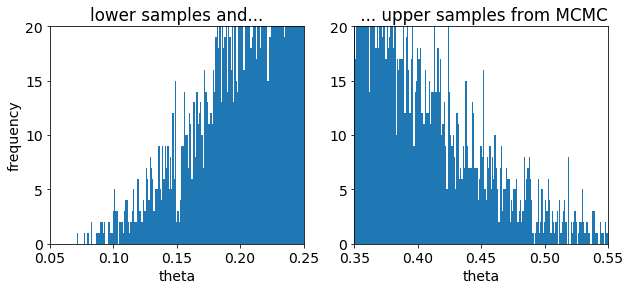

In [18]:
'''fine grained histogram 1/1000. Where to set HDI borders?'''
bins = np.linspace(-0.0005, 1.0005, 1001+1)
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.hist(thechain, bins=bins)
plt.title('lower samples and...')
plt.xlim(0.05, 0.25)
plt.ylim(0, 20)
plt.xlabel('theta')
plt.ylabel('frequency');
fig.add_subplot(1,2,2)
plt.hist(thechain, bins=bins)
plt.title(' ... upper samples from MCMC')
plt.xlim(0.35, 0.55)
plt.ylim(0, 20)
plt.xlabel('theta');

> einige sind schlechte ausgeloest

### HDI einer (angepaßten) theoretischen Verteilung
- gemäß Modell an Posterior Samples anfitten
- daraus HDI berechnen

theta^ = 0.2951
HDI(fit, 95.0%) = [0.122, 0.471]


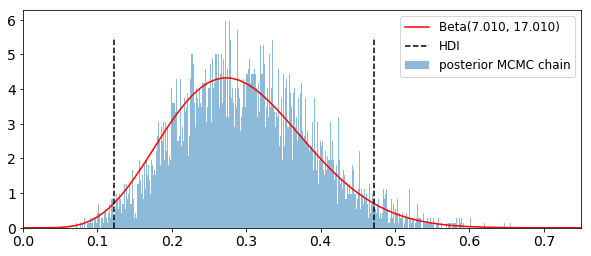

In [19]:
'''calculate HDI of theoretical distribution model (fit to posterior chain)'''
import AngStII_Bayes as bayes

z, N = (7, 24)
theta_hat = np.median(thechain)
print('theta^ = {:.4f}'.format(theta_hat))

fig = plt.figure(figsize=(10, 4))
plt.xlim(0.0, 0.75)
plt.hist(thechain, bins=bins, normed=True, alpha=.5, label='posterior MCMC chain')

a, b = (7+.01, 24-7+.01)
x = np.linspace(0.0, 1.0, 100+1)
plt.plot(x, stats.beta(a, b).pdf(x), 'r-', 
         label='Beta({:.3f}, {:.3f})'.format(a, b))

alpha = 0.95  # credibility mass 
hdif = bayes.HDIofICDF(stats.beta, credmass=alpha, a=a, b=b)
print('HDI(fit, {:.1f}%) = [{:.3f}, {:.3f}]'.format(100*alpha, hdif[0], hdif[1]))
plt.plot(2*[hdif[0]], [0.0, 5.5], 'k--', label='HDI')
plt.plot(2*[hdif[1]], [0.0, 5.5], 'k--')
plt.legend(loc='upper right', fontsize=12);

In [20]:
'''Methods calculating HDI'''
hdic = bayes.HDIofMCMC(thechain)
print('HDI(chain, 95%) = [{:.3f}, {:.3f}]'.format(hdic[0], hdic[1]))

HDI(chain, 95%) = [0.126, 0.468]


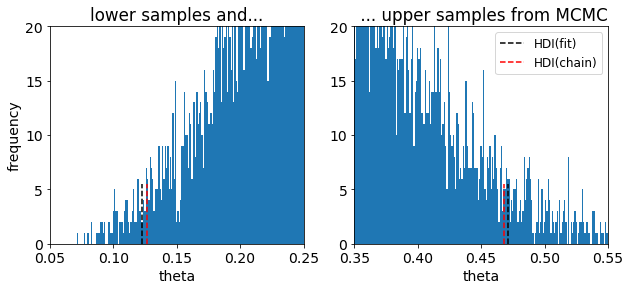

In [21]:
'''compare the HDI solutions'''
bins = np.linspace(-0.0005, 1.0005, 1001+1)
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.hist(thechain, bins=bins)
plt.plot(2*[hdif[0]], [0.0, 5.5], 'k--', label='HDI(fit)')
plt.plot(2*[hdic[0]], [0.0, 5.5], 'r--', label='HDI(chain)')
plt.title('lower samples and...')
plt.xlim(0.05, 0.25)
plt.ylim(0, 20)
plt.xlabel('theta')
plt.ylabel('frequency')
fig.add_subplot(1,2,2)
plt.hist(thechain, bins=bins)
plt.plot(2*[hdif[1]], [0.0, 5.5], 'k--', label='HDI(fit)')
plt.plot(2*[hdic[1]], [0.0, 5.5], 'r--', label='HDI(chain)')
plt.title(' ... upper samples from MCMC')
plt.xlim(0.35, 0.55)
plt.ylim(0, 20)
plt.xlabel('theta')
plt.legend(loc='upper right', fontsize=12);

In [22]:
n_inner = len(thechain[np.logical_and(thechain>=hdic[0], thechain<=hdic[1])])
n_total = len(thechain)
print('HDI(chain) contains {:.3f}% values'.format(n_inner/n_total*100))

HDI(chain) contains 95.014% values


----

# Entscheidung durch Modell-Vergleich

Andere Art der Fragestellung:

#### Ist ein Modell mit einem spezifischen Prior (*Nullhypothese*) besser als eines mit einem uninformativen Prior?

Dann wird die Nullhypothese nicht verworfen.

## Obiges Beispiel (z=7, N=24)

Nullhypothese $H_0: \; \theta_0=\frac{1}{2}$
$$p(z,N|M_0) = \theta_0^z (1-\theta_0)^{N-z}$$
Alternativhypothese $H_A:$
$$p(z,N|M_A) = B(z+a_A, N-z+b_A)\big{/}B(a_A, b_A)$$

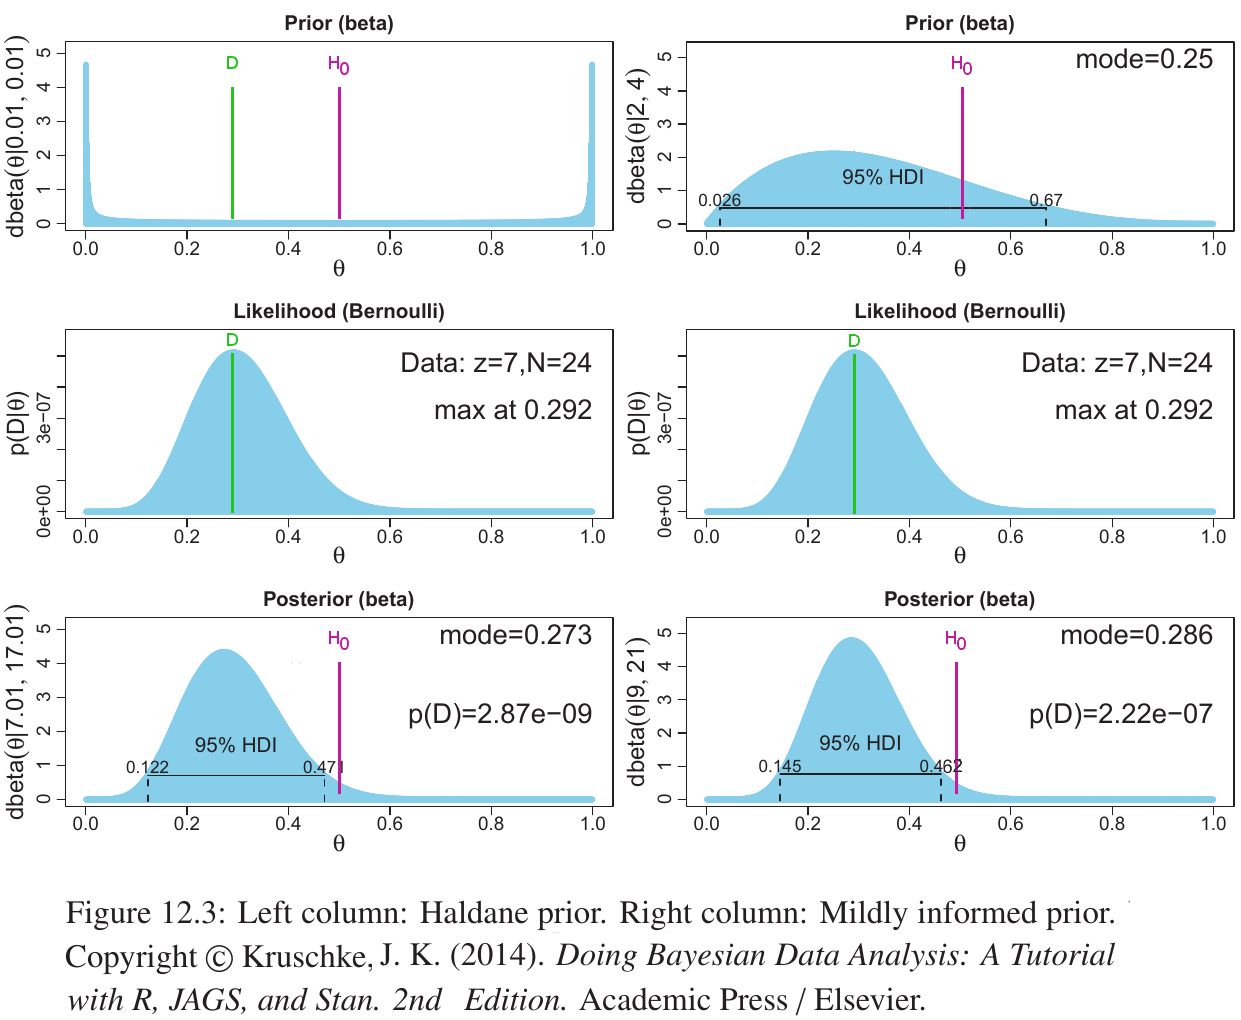

In [13]:
Image(filename='images/Kruschke2nd_ComparisonSavageDickey1_Fig12p3.png', width='50%')

#### Bayes-Faktor

$$\frac{p(z,N|M_A)}{p(z,N|M_0)} = \frac{B(z+a_A,N-z+b_A)\big{/}B(a_A, b_A)}{\theta_0^z (1-\theta_0)^{N-z}}$$

#### Ergebnis

$$\frac{p(z,N|M_{A})}{p(z,N|M_{0})} = \left\{ 
\begin{matrix}
3.7227 & \mathrm{for}\; a_{A}=2,\;\; b_{A}=4 \\
1.9390 & \mathrm{for}\; a_{A}=b_{A}=1.000 \\
0.4211 & \mathrm{for}\; a_{A}=b_{A}=0.100 \\
0.0481 & \mathrm{for}\; a_{A}=b_{A}=0.010 \\
0.0049 & \mathrm{for}\; a_{A}=b_{A}=0.001 \\
\end{matrix} \right.$$


# Test *Modellvergleich*

Verschachtelte Modelle (*nested models*)
- 0) Einfaches Modell mit Parameter $\theta=\theta_0$ (Nullhypothese)
- A) Erweitertes Modell mit freiem Parameter $\theta$ (Alternative Hypothese $\theta\neq\theta_0$)

## *Savage-Dickey Methode* - Bayes-Faktoren anschaulich

$$BF_{0A} = \frac{p(D|H_0)}{p(D|H_A)} = \frac{p(\theta=\theta_0|D,H_A)}{p(\theta=\theta_0|H_A)}$$

Die *Savage-Dickey Methode*
- vergleicht den Bayes-Faktor nur im erweiterten Modell A)
- vergleicht die Posterior- mit der Prior-Wahrscheinlichkeitsdichte
    - für den interessierenden Parameterwert $\theta=\theta_0$

### Auch hier: Abhängigkeit BF vom Prior

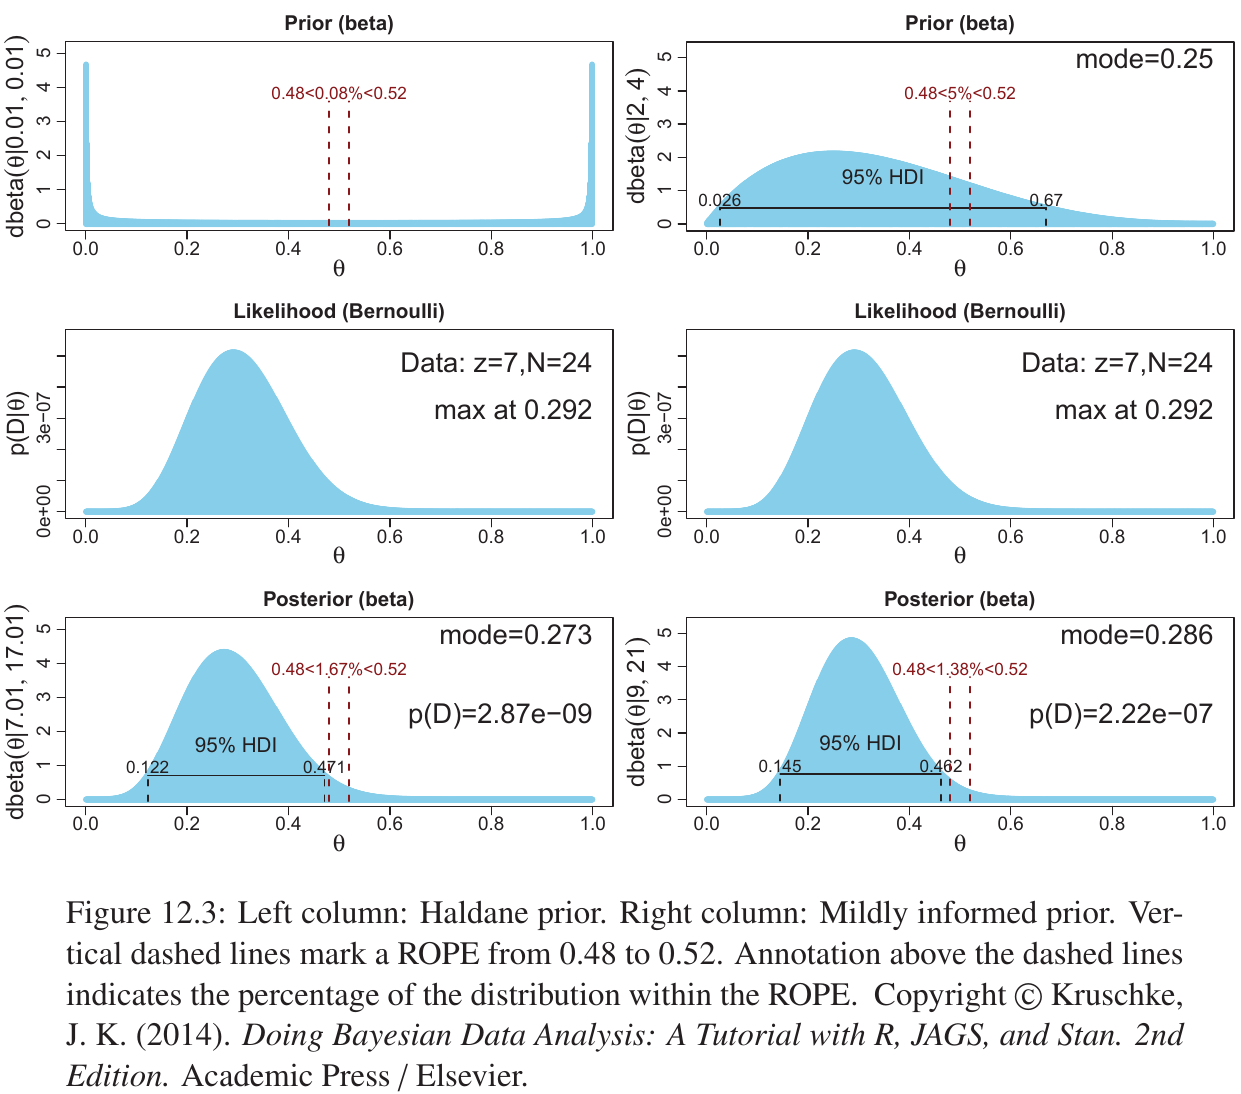

In [14]:
Image(filename='images/Kruschke2nd_ComparisonSavageDickey2_Fig12p3.png', width='50%')

# Entscheidungen treffen

## 1. Bayes-Faktor

Der Bayes-Faktor ändert sich stark mit dem Prior (=Vorwissen)
- nicht verwerfen von $H_0$ für $(a, b)$ mit $a=b < 0.01$
- verwerfen von $H_0$ für $(a=2, b=4)$

## 2. Posteriors

Sieht man sich die Posterior-Verteilung und die HDIs an, so unterscheiden die sich gar nicht so sehr, alle würden die Nullhypothese verwerfen.

## 3. Übergeordnetes Gesamt-Modell

**Ein** Hierarchisches Modell

- Modell-Vergleich
    - übergeordneter Modell-Parameter
    - entscheidet sich für/gegen das Null-Modell
    - Bayes-Faktor
- Parameter-Schätzung
    - vergleicht Null-Parameter mit unvoreingenommenem Prior
    - zeigt Posterior
    - HDI $\in$ ROPE?

Beide Varianten des einen Modells können ausgewertet werden.
- müssen nicht übereinstimmen
- Anwendungsabhängig, was bevorzugen
- Null-Parameter muß Bedeutung haben (Theorie, Literatur, Entscheidung, ...)
- Meist ist Posterior (Parameter-Schätzung) aussagekräftiger

#### Einschränkungen

- ROPE 
    - muß eng sein
    - muß angemessen gewählt werden (Genauigkeit)
- Prior und Posterior Verteilungen sollten glatt sein im Bereich
- Näherung $\Leftrightarrow$ exakt = @Punkt

#### Literatur

- Wagenmakers, Lodewyckx, Kuriyal, Grasman: Bayesian hypothesis testing for psychologists: A tutorial on the Savage–Dickey method. (2010)

# Trennschärfe

Macht (*power*) eines Tests: kann das Ziel erreicht werden?

#### Ziele

- Verwerfen der Nullhypothese
    - ROPE außerhalb 95% HDI
- Akzeptieren der Nullhypothese
    - 95% HDI innerhalb ROPE 
- Präzision
    - 95% HDI schmaler als geforderte Genauigkeit


## Problematik

- Wie in der klassischen Statistik verbleibt eine Irrtumswahrscheinlichkeit von 5%
- Daten sind Zufallsvariablen und können auch zufällig
    - 24 von 30 mal Kopf zeigen, *obwohl* Münze fair ist
    - Placebo wirkungsvoller als Medikament in getesteter Gruppe
    - ...

### Vorsichtsmaßnahmen

- Rauschen weitestgehend vermeiden
    - Zufall einhalten 
    - Einflüsse ausschließen (Magnetfeld, Kontrollgruppe an Patienten angleichen)
    - Effekt verstärken (Labor)

## Anzahl Meßdaten

- Störeinflüsse mitteln sich heraus
- Mittelwertsfehler

## Simulation

#### Parameter 

- aus Gesamtraum
- aus Theorie
- aus Vorexperimenten

#### Mögliche Daten simulieren

- "Ziehen" aus Verteilungen(Parameter)
- Entsprechend nachher der Versuchsdurchführung

#### Bayes-Statistik anwenden

- Posterior 
- Schätzer
- HDI

#### Ergebnis des simulierten Posteriors wie benötigt? 

- ROPE & HDI

#### oft wiederholen

- Ziel meist erreicht?
- Bayes-Statistik darauf anwenden

#### Entscheidung

- Nein?
    - Stichprobenumfang erhöhen
- Ja?
    - Versuch genau so durchführen
    - Messen und auf Daten anwenden

## Stichprobenumfang

#### klassiche Statistik

- Varianz wird mit steigender Datenanzahl kleiner ("Gesetz der großen Zahl")

#### Bayes Statistik

- Posterior wird mit steigender Datenanzahl schmaler und überstimmt jeden Prior.
- Bayes-Faktor in Modellvergleich soll bestimmte Höhe erreichen

## Abbruch-Kriterium

- Daten sammeln bis zum Abbruchkriterium N ist Standard.

- Daten sammeln bis zum Abbruchkriterium "Nullhypothese verwerfen" $= p<0.05$ 
    - führt zu Ablehnung der Nullhypothese in 100% der Fälle(!)
    - Grund: es finden sich selbst wenn die Nullhypothe zutrifft in 5% der Fälle Ausnahmen, die ein Verwerfen rechtfertigen würden.
    - MCMC Ergebnisse sind immer "biased" zu einem Schwanz der Verteilung hin
        - da Anhäufungen von Extremwerten bevorzugt werden 
        - und die entgegengesetzten Extremwerte nach dem Abbruch keine Chance mehr bekommen

### Ausweg

#### NHST: 

- Festlegen des Stichprobenumfangs nach vorheriger Bestimmung der Macht des Tests.
- Registrieren des Versuchs

#### Bayes:

- Festlegen des Stichprobenumfangs anhand geforderter Genauigkeit.
- Genauigkeit ist nicht vom Wert beeinflußt
    - Ausnahmen: Poisson-Statistik, Beta-Verteilung 
        - (letztere jedoch nur leicht, daher Ergebnis trotzdem verwendbar)

# Daten-Modell-Vergleich

- Posterior liefert Parameter
- Simuliere Daten mit diesen Parametern
- Sehen diese simulierten Daten so aus wie die gemessenen?
- Ja: 
    - Modell ist angemessen
    - Parameter verwendbar
- Nein:
    - Modell ist unangemessen
    - Parameter sinnlos

# Zusammenfassung

## *credible intervals*, *HDI*

- die Posterior-Verteilung $p(\theta|D)$ ist die interessante Größe 
- das Posterior 95%-HDI enthält zu 95% den wahren Wert $\theta_0$
    - kann eine Nullhypothese ausschließem
    - kann durch Vergleich mit ROPE die Nullhypothese *für praktische Belange* akzeptieren
- verlangt Prior / erlaubt Vorwissen
    - Einfluß auf Breite und Lage des HDI
    - jeder nach seiner Fasson


## Konfidenzintervalle der Frequentistischen Statistik

- können eine Nullhypothese verwerfen
- können nicht die Nullhypothese akzeptieren
- sagen nichts über Wahrscheinlichkeit des wahren Parameters aus
    - schon gar nicht über eine Verteilung des wahren Parameters
- setzen Normalverteilung voraus (bei t-Test)
- hängen ab von der Intention, Datenerhebungsstrategie
- erlauben keine Abschätzung der Macht des Tests

## Bayes-Faktor

- Kann zur Entscheidung verwendet werden
    - vergleicht Likelihoods unter Nullhypothese mit Alternativ-Modell
- Starke Abhängigkeit von Prior-Auswahl
    - Prior sinnvoll zur Fragestellung wählen
- Überprüfen, ob Ziel erreicht
    - Liegt die Nullhypothese in der Nähe des Posterior HDI?
- Oft ist Kriterium HDI vs. ROPE sinnvoller

# Literatur

#### Buch

- J. K. Kruschke: "Doing Bayesian Data Analysis, 2nd. A Tutorial with R, JAGS and Stan" Academic Press (2015)

#### Wissenschaftliche Artikel

[Morey et.al: The fallacy of placing confidence in confidence intervals (2016)](https://link.springer.com/article/10.3758/s13423-015-0947-8) (sehr nett lesbar)

#### Web-Links

[Kruschke: Tail probability or highest density interval?](http://doingbayesiandataanalysis.blogspot.de/2013/07/decisions-from-posterior-distributions.html)


# Fragen?